In [29]:
import requests 
import pandas as pd
import re
import urllib.parse
import matplotlib.pyplot as plt
import numpy as np

Получим датасет

In [30]:
df = pd.concat(map(lambda x : pd.read_csv(f"ffkkmo_judges_{x}_dump.csv"), ['2021', '2122', '2223', '2324', '2425'])).reset_index(drop=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [31]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24959 entries, 0 to 24958
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      24959 non-null  object
 1   place     24959 non-null  object
 2   online    24959 non-null  object
 3   function  24959 non-null  object
 4   name      24864 non-null  object
dtypes: object(5)
memory usage: 975.1+ KB


,date,place,online,function,name
0,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Referee,Павел ТАТАРЕНКО
1,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Technical Controller,Ольга КОВАЛЬ
2,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Technical Specialist,Михаил КАЗАКОВ
3,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Judge No.1,Павел ТАТАРЕНКО
4,27.09.2020,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Judge No.2,Юлия СОЛОМИНА


In [32]:
# Удалим строки без судей
df = df.dropna(subset=['function', 'name'])

In [33]:
# Приведем типы данных
df['date'] = df['date'].str.strip()
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [34]:
# Добавим год
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['season'] = df['date'].apply(lambda x: f"{x.year-2001}{x.year-2000}" if x.month < 8 else f"{x.year-2000}{x.year-1999}")

In [35]:
def replace_duplicates(df, keyword, name, field='function'):
    uniquenames = [ s for s in df[field].unique() if keyword.findall(str(s).lower()) ]
    return df[field].replace(uniquenames, name)

In [36]:
def get_regex(str_val):
    return re.compile((r"(" + str_val + ")").lower())

In [37]:
df.name = df.name.str.strip()
df.name = df.name.str.replace("ё", "е")
df.name = df.name.str.replace("Ё", "Е")
df.name = df.name.str.replace("  ", " ")

In [38]:
[ s for s in df.name.unique() if get_regex('ей РОГ').findall(str(s).lower()) ]

['Алексей РОГОЗИНСКИЙ',
 'Mr. Алексей РОГОЗИНСКИЙ',
 'Аллексей РОГОЗИНСКИЙ',
 'Алескей РОГОЗИНСКИЙ',
 'Алексей РОГОЗОНСКИЙ']

In [39]:
df.drop(df[[True if len(x) <= 1 else False for x in df.name.str.split()]].index, inplace=True)

In [40]:
df.name = [' '.join([x[1], x[2].upper()]) if len(x) > 2 else ' '.join([x[0], x[1].upper()]) for x in df.name.str.split()]

In [41]:
df.function = replace_duplicates(df, get_regex('специалист'), 'Технический специалист')
df.function = replace_duplicates(df, get_regex('Specialist'), 'Технический специалист')
df.function = replace_duplicates(df, get_regex('контролер'), 'Технический контролер')
df.function = replace_duplicates(df, get_regex('Controller'), 'Технический контролер')
df.function = replace_duplicates(df, get_regex('Replay'), 'Оператор видеоповтора')
df.function = replace_duplicates(df, get_regex('Data'), 'Оператор ввода данных')
df.function = replace_duplicates(df, get_regex('Referee'), 'Рефери')
df.function = replace_duplicates(df, get_regex('1'), 'Судья')
df.function = replace_duplicates(df, get_regex('2'), 'Судья')
df.function = replace_duplicates(df, get_regex('3'), 'Судья')
df.function = replace_duplicates(df, get_regex('4'), 'Судья')
df.function = replace_duplicates(df, get_regex('5'), 'Судья')
df.function = replace_duplicates(df, get_regex('6'), 'Судья')
df.function = replace_duplicates(df, get_regex('7'), 'Судья')
df.name = replace_duplicates(df, get_regex('шуркалова'), 'Елизавета ВЛАСЕНКО', field='name')
df.name = replace_duplicates(df, get_regex('ей РОГ'), 'Алексей РОГОЗИНСКИЙ', field='name')
df.function.unique()

array(['Рефери', 'Технический контролер', 'Технический специалист',
       'Судья', 'Оператор видеоповтора', 'Оператор ввода данных'],
      dtype=object)

In [42]:
len(df[df['function'] == 'Рефери'])

3214

In [43]:
len(df[df['function'] == 'Судья'])

13193

In [44]:
len(df)

24844

In [45]:
df.reset_index(inplace=True, drop=True)
df.to_csv("ffkkmo_judges_clean.csv")
df

,date,place,online,function,name,year,month,season
0,2020-09-27,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Рефери,Павел ТАТАРЕНКО,2020,9,2021
1,2020-09-27,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Технический контролер,Ольга КОВАЛЬ,2020,9,2021
2,2020-09-27,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Технический специалист,Михаил КАЗАКОВ,2020,9,2021
3,2020-09-27,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Судья,Павел ТАТАРЕНКО,2020,9,2021
4,2020-09-27,"г. Лыткарино, ул. Советская д.9а, ЛСК «Лыткарино»",http://ffkkmo.ru/events/2021/lytkarino0927/,Судья,Юлия СОЛОМИНА,2020,9,2021
...,...,...,...,...,...,...,...,...
24839,2025-06-14,"г. Долгопрудный, пр-кт Ракетостроителей, д. 4,...",http://ffkkmo.ru/events/2425/dp1406/,Технический специалист,Евгений ПРОКОФЬЕВ,2025,6,2425
24840,2025-06-14,"г. Долгопрудный, пр-кт Ракетостроителей, д. 4,...",http://ffkkmo.ru/events/2425/dp1406/,Судья,Светлана СОЛОМИНА,2025,6,2425
24841,2025-06-14,"г. Долгопрудный, пр-кт Ракетостроителей, д. 4,...",http://ffkkmo.ru/events/2425/dp1406/,Судья,Даниил СТАРОВ,2025,6,2425
24842,2025-06-14,"г. Долгопрудный, пр-кт Ракетостроителей, д. 4,...",http://ffkkmo.ru/events/2425/dp1406/,Судья,Елена БОЛДЕНКО,2025,6,2425


In [46]:
pd.pivot_table(df.drop_duplicates(['date', 'name', 'function']), values='date', index='name', columns='function', aggfunc='count')

function,Оператор ввода данных,Оператор видеоповтора,Рефери,Судья,Технический контролер,Технический специалист
name,,,,,,
Александр КОНДАКОВ,NaN,NaN,NaN,NaN,NaN,13.0
Александр КУЗНЕЦОВ,NaN,NaN,NaN,NaN,NaN,1.0
Александр ПОЛЯКОВ,NaN,NaN,NaN,11.0,NaN,NaN
Александр САМОХВАЛОВ,NaN,NaN,NaN,NaN,NaN,25.0
Александра АВСТРИЙСКАЯ,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...
Яна СУСЛЕНКО,NaN,NaN,3.0,5.0,1.0,NaN
с С,NaN,NaN,NaN,1.0,NaN,NaN
судья №1,NaN,NaN,NaN,1.0,NaN,NaN


In [47]:
temp_df = df[df.season == '2425'].drop_duplicates(['date', 'name', 'function']).groupby(['function', 'name']).count()['date']

In [48]:
temp_df.loc['Технический специалист'].sort_values(ascending=False)

name
Станислав КОВАЛЕВ       11
Евгений ПРОКОФЬЕВ        8
Александр САМОХВАЛОВ     7
Александр КОНДАКОВ       6
Михаил КАЗАКОВ           6
Елизавета РАЧЕВА         5
Андрей ЛЕБЕДЬ            3
Георгий КОЗАЧИНСКИЙ      2
Мария СЕМЕНОВА           2
Оксана АНДРИЕНКО         2
Алксандр КОНДАКОВ        1
Анастасия ИЛЬЯНОВА       1
Владислав МИРЗОЕВ        1
Наталия ЛЕБЕДЕВА         1
Name: date, dtype: int64

In [49]:
temp_df.loc['Технический контролер'].sort_values(ascending=False)

name
Дарья ФИЛЯКИНА           15
Ольга КОВАЛЬ             10
Полина МАЗОРЧУК           8
Елена МЕЛИКОВА            5
Елизавета КИРИЛЛОВА       3
Алексей УСАНОВ            2
Юлия ПТИЦЫНА              2
Алла ШЕХОВЦОВА            1
Анастасия ШЕРЕМЕТЬЕВА     1
Антон ШАРОВ               1
Елена НОВИКОВА            1
ПОЛЯКОВА (ПОНОМАРЕВА)     1
ПТИЦЫНА (СОЛОМИНА)        1
Полина ГЛУШАК             1
Полина МОЗАРЧУК           1
Яна СУСЛЕНКО              1
Name: date, dtype: int64

In [50]:
temp_df.loc['Оператор ввода данных'].sort_values(ascending=False)

name
Алексей РОГОЗИНСКИЙ    31
Алексей ПОЛЕТОВ         2
Владислав ГРИЦАЙ        2
Евгений ПРОКОФЬЕВ       2
Евгения СУББОТИНА       1
Михаил КАЗАКОВ          1
Name: date, dtype: int64

In [51]:
temp_df.loc['Рефери'].sort_values(ascending=False)

name
Елена КАЛИНКИНА          17
Светлана СОЛОМИНА        10
Евгения СУББОТИНА         5
Елена МЕЛИКОВА            5
Дарья ФИЛЯКИНА            4
Юлия СОЛОМИНА             4
Дарья НУЖДИНА             2
Анастасия АГИБАЛОВА       1
Анастасия ШЕРЕМЕТЬЕВА     1
Елизавета ВЛАСЕНКО        1
Елизавета КИРИЛЛОВА       1
Ольга КОВАЛЬ              1
Сергей ЧЕМОДАНОВ          1
Татьяна ФЕДОРОВА          1
Яна СУСЛЕНКО              1
Name: date, dtype: int64

In [52]:
temp_df.loc['Судья'].sort_values(ascending=False).head(20)

name
Елена КАЛИНКИНА          21
Елена БОЛДЕНКО           18
Светлана СОЛОМИНА        15
Валентина ВОЛКОВА        13
Александра АСТАФЬЕВА     12
Анастасия ГОРЯЧЕВА       10
Татьяна КАМАНИНА         10
Дарья ФИЛЯКИНА            9
Людмила ПРОКОФЬЕВА        8
Екатерина РОМАДАНОВА      7
Евгения СУББОТИНА         7
Екатерина ЮДКИНА          6
Юлия СОЛОМИНА             6
Елена МЕЛИКОВА            6
Полина МАЗОРЧУК           5
Дарья НУЖДИНА             5
Александра СУДАРИКОВА     5
Вера НАДЕЕВА              4
Елена НОВИКОВА            3
Елизавета КИРИЛЛОВА       3
Name: date, dtype: int64

In [53]:
temp_df.index = temp_df.index.swaplevel(0, 1)

In [54]:
def judge_in_seasons(df, name):
    data = df[df.name == name].groupby(['season']).count()['title']
    ax = data.plot(
        kind='bar', figsize=(20, 5), grid=True
    )
    major_ticks = np.arange(0, max(data) + 1, 1)
    ax.set_yticks(major_ticks)
    plt.title(name, fontsize=32)
    plt.xlabel('Сезон', fontsize=16)
    plt.ylabel(f'Количество участий', fontsize=18)
    plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');

In [55]:
def judges_in_season(df, season=None, limit=100, plot=True, sort_col='date'):
    if season is None:
        data = df
    else:
        data = df[df['season'] == season]
    data = data.groupby(['name']).count().sort_values(
        by=sort_col, ascending=False).head(limit)['date']
    if plot:
        ax = data.plot(
            kind='bar', figsize=(20, 5), grid=True
        )
        major_ticks = np.arange(0, max(data) + 1, 1)
        if season is not None:
            ax.set_yticks(major_ticks)
            plt.title("Сезон " + season, fontsize=32)
        plt.xlabel('Судья', fontsize=16)
        plt.ylabel(f'Количество участий', fontsize=18)
        plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');
    else:
        return data

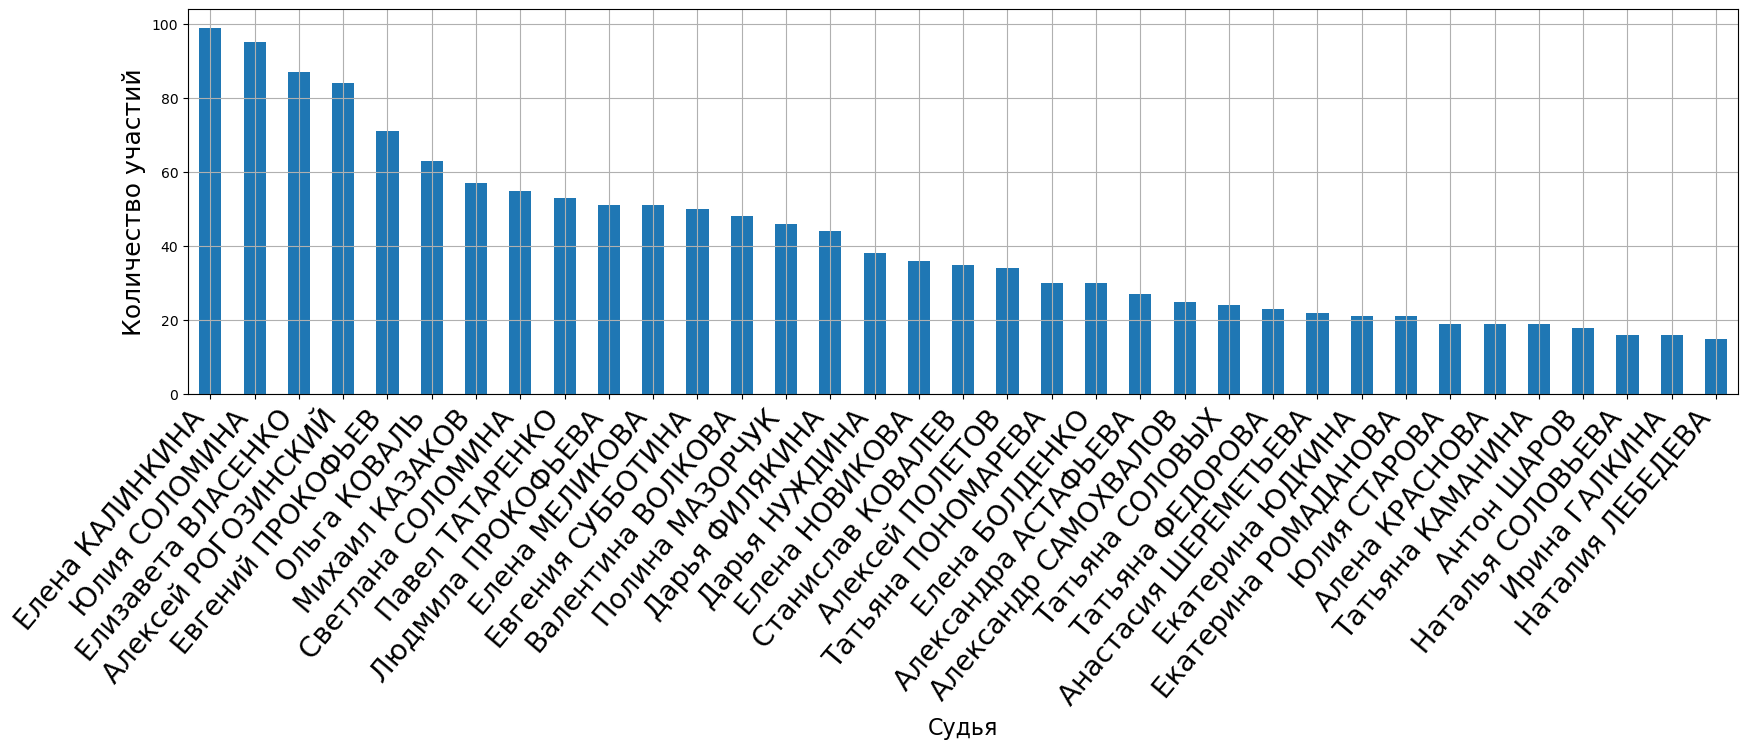

In [56]:
judges_in_season(df.drop_duplicates(['date', 'name']), limit=35)

In [57]:
judge_in_seasons(df.drop_duplicates(['date', 'name']), 'Павел ТАТАРЕНКО')

KeyError: 'title'

In [ ]:
df[df.name == 'Елизавета ВЛАСЕНКО']